230
230
415
415
415
415
230
11000


AttributeError: 'function' object has no attribute 'write'

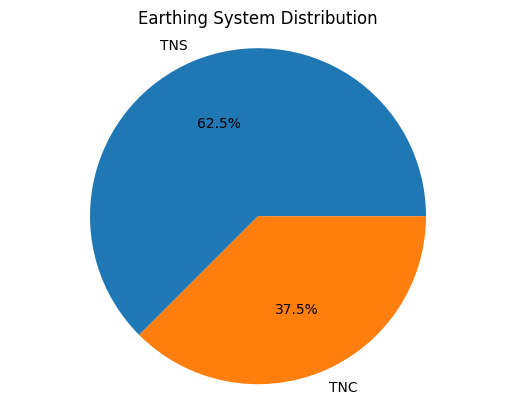

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

A = "floor.csv"
df = pd.read_csv(A)
B="Insulate.csv"
mf=pd.read_csv(B)


df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)


def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def insulateresult(Nom_CVolt, T_Volt, Insu_R):
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    else:
        return "Invalid input"
    
def resistancerang(length):
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1

def insulationrang(length):
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulateresult(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def insulation_table(mf, doc):
    table_data = mf.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)                        # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8                                                                 # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulationrang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(column_widths[num_cols])  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    plt.savefig("scatter_graph.png")
    resistance_graph = io.BytesIO()
    plt.savefig(resistance_graph)
    plt.close()
    return resistance_graph

def insulation_graph(mf):
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    plt.bar(x, y)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    insulation_graph= io.BytesIO()
    plt.savefig(insulation_graph)
    plt.close()
    return insulation_graph

def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    plt.savefig('pie_chart.png')
    resistance_pie= io.BytesIO()
    plt.savefig(resistance_pie)
    plt.close()
    return resistance_pie

def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%")
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    insulation__pie = io.BytesIO()
    plt.savefig(insulation_pie)
    plt.close()
    return insulation_pie

def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    Y="Insulate.csv"
    mf=pd.read_csv("Insulate.csv")

    doc = docx.Document()
    doc.add_heading('TESTING REPORT', 0)

    doc = resistance_table(df, doc)
    doc.add_page_break()
    doc = insulation_table(mf, doc)

    resistance_graph = resistance_graph(df)
    doc.add_picture(resistance_graph, width=Inches(5), height=Inches(3))

    insulation_graph = insulation_graph(mf)
    doc.add_picture(insulation_graph,width=Inches(5), height=Inches(3))

    resistance_pie= resistance_pie(df)
    doc.add_picture(resistance_pie, width=Inches(5), height=Inches(3))
   
    ins_pie= insulation_pie(mf)
    doc.add_picture(ins_pie,width=Inches(5), height=Inches(3))
    
    doc.save("scriptreport.docx")


main()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

A = "floor.csv"
df = pd.read_csv(A)
B="Insulate.csv"
mf=pd.read_csv(B)


df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)


def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def insulateresult(Nom_CVolt, T_Volt, Insu_R):
    if Nom_CVolt <= 50:
        if Insu_R >= 0.5 and T_Volt == 250:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif 50 < Nom_CVolt <= 500:
        if Insu_R >= 1 and T_Volt == 500:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    elif Nom_CVolt > 500:
        if Insu_R >= 1 and T_Volt == 1000:
            return "Satisfactory"
        else:
            return "Unsatisfactory"
    else:
        return "Invalid input"
    
def resistancerang(length):
    res1 = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res1.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res1

def insulationrang(length):
    res2 = []
    for row in range(length):  # Adjusted the range to start from 0
        Nom_CVolt = mf.iloc[row, 7]
        T_Volt = mf.iloc[row, 9]
        Insu_R = mf.iloc[row, 13]
        res2.append(insulateresult(Nom_CVolt, T_Volt, Insu_R))
        print(Nom_CVolt)
    return res2


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def insulation_table(df, doc):
    table_data = df.iloc[:, 0:]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)                        # Add +1 for the "Result" column
    table.style = "Table Grid"
    table.autofit = False
    column_widths = {
        0: 0.2,
        1: 0.51,
        2: 0.55,
        3: 0.54,
        4: 0.38,
        5: 0.4,
        6: 0.5,
        7: 0.48,
        8: 0.5,
        9: 0.43,
        10: 0.4,
        11: 0.4,
        12: 0.4,
        13: 0.4,
        num_cols: 0.8                                                                 # Width for the "Result" column
    }
    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])
    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            table.cell(i, j).text = str(value)
    Results = insulationrang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(column_widths[num_cols])  # Set width for the "Result" column
    for i in range(0, num_rows):
        res_index = i - 1
        table.cell(i + 1, num_cols).text = Results[res_index]
    font_size = 6.5

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc

def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    plt.savefig("scatter_graph.png")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1

def insulation_graph(mf):
    x = mf["Location"]
    y = mf["Nominal Circuit Voltage"]
    plt.bar(x, y)
    plt.xlabel("Location")
    plt.ylabel("Nominal Circuit Voltage")
    plt.title("Nominal Circuit Voltage by Location")
    plt.savefig("chart.png")
    graph2 = io.BytesIO()
    plt.savefig(graph2)
    plt.close()
    return graph2

def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    plt.savefig('pie_chart.png')
    graph3= io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3

def insulation_pie(mf):
    earthing_system_counts = mf["Earthing System"].value_counts()
    plt.pie(earthing_system_counts, labels=earthing_system_counts.index, autopct="%1.1f%%")
    plt.axis("equal")
    plt.title("Earthing System Distribution")
    plt.savefig("pie_chart.png")
    graph4 = io.BytesIO()
    plt.savefig(graph4)
    plt.close()
    return graph4

def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")

    Y="Insulate.csv"
    mf=pd.read_csv("Insulate.csv")

    doc = docx.Document()
    doc.add_heading('TESTING REPORT', 0)

    doc = resistance_table(df, doc)
    doc.add_page_break()
    doc = insulation_table(mf, doc)

    graph_resistance = resistance_graph(df)
    doc.add_picture(graph_resistance, width=Inches(5), height=Inches(3))

    graph_insulation = insulation_graph(mf)
    doc.add_picture(graph_insulation,width=Inches(5), height=Inches(3))

    pie_resistance= resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
   
    pie_insulation= insulation_pie(mf)
    doc.add_picture(pie_insulation,width=Inches(5), height=Inches(3))
    
    doc.save("scriptreport.docx")


main()


230
230
415
415
415
415
230
11000


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

M = "floor.csv"
df = pd.read_csv(M)

df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)



def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def resistancerang(length):
    res = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc



def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")
    doc = docx.Document()
    doc.add_heading('FLOOR TEST', 0)
    doc = resistance_table(df, doc)
    graph_resistance = resistance_graph(df)
    doc.add_picture(resistance_graph, width=Inches(5), height=Inches(3))
    pie_resistance = resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
    doc.save("floor.docx")


main()


AttributeError: 'function' object has no attribute 'seek'

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import docx
from docx import Document
import csv
import io
from docx.shared import Inches
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.shared import Pt, RGBColor

M = "floor.csv"
df = pd.read_csv(M)

df['Applied Test Voltage (V)'] = pd.to_numeric(df['Applied Test Voltage (V)'], errors='coerce')
df['Measured Output Current (mA)'] = pd.to_numeric(df['Measured Output Current (mA)'], errors='coerce')

df['EffectiveResistance'] = df['Applied Test Voltage (V)'] / df['Measured Output Current (mA)']
df.to_csv('floorfinal.csv', index=False)



def resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc):
    if Nom_EVolt <= 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 50:
            return "pass"
        else:
            return "fail"
    elif Nom_EVolt > 500 and Dist_loc >= 1:
        if ATV == Nom_EVolt and Eff_Floor >= 100:
            return "pass"
        else:
            return "fail"
    elif Dist_loc <= 1:
        return "fail"
    else:
        return "Invalid input"


def resistancerang(length):
    res = []
    for row in range(length):
        Nom_EVolt = df.iloc[row, 5]
        Dist_loc = df.iloc[row, 4]
        ATV = df.iloc[row, 6]
        Eff_Floor = df.iloc[row, 8]
        res.append(resistanceresult(Nom_EVolt, ATV, Eff_Floor, Dist_loc))
    return res


def resistance_table(df, doc):
    table_data = df.iloc[:, :]
    num_rows, num_cols = table_data.shape
    table = doc.add_table(rows=num_rows + 1, cols=num_cols + 1)
    table.style = "Table Grid"
    table.autofit = False

    column_widths = {
        0: 0.4,
        1: 0.6,
        2: 0.7,
        3: 0.65,
        4: 0.5,
        5: 0.5,
        6: 0.5,
        7: 0.5,
        8: 0.5,
        9: 0.5,
        10:0.7,
        11:0.6,
    }

    for j, col in enumerate(table_data.columns):
        table.cell(0, j).text = col
        table.cell(0, j).width = Inches(column_widths[j])

    for i, row in enumerate(table_data.itertuples(), start=1):
        for j, value in enumerate(row[1:], start=0):
            if isinstance(value, float):
                value = "{:.2f}".format(value)
            table.cell(i, j).text = str(value)

    Results = resistancerang(num_rows)
    table.cell(0, num_cols).text = "Result"
    table.cell(0, num_cols).width = Inches(0.6)
    for i in range(num_rows):
        table.cell(i + 1, num_cols).text = Results[i]
    table.alignment = WD_PARAGRAPH_ALIGNMENT.LEFT
    font_size = 8

    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(font_size)

    return doc



def resistance_graph(df):
    x = df["Distance from previous test location (m)"]
    y = df["EffectiveResistance"]
    plt.scatter(x, y)
    plt.xlabel("Distance from previous test location (m)")
    plt.ylabel("Effectivefloor")
    plt.title("Distance from previous test location (m) VS Effectivefloor")
    graph1 = io.BytesIO()
    plt.savefig(graph1)
    plt.close()
    return graph1


def resistance_pie(df):
    df['Result'] = resistancerang(df.shape[0])
    df_counts = df['Result'].value_counts()
    labels = df_counts.index.tolist()
    values = df_counts.values.tolist()

    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Test Results')
    graph3 = io.BytesIO()
    plt.savefig(graph3)
    plt.close()
    return graph3


def main():
    M = "floor.csv"
    df = pd.read_csv("floorfinal.csv")
    doc = docx.Document()
    doc.add_heading('FLOOR TEST', 0)
    doc = resistance_table(df, doc)
    graph_resistance = resistance_graph(df)
    doc.add_picture(graph_resistance, width=Inches(5), height=Inches(3))
    pie_resistance = resistance_pie(df)
    doc.add_picture(pie_resistance, width=Inches(5), height=Inches(3))
    doc.save("floor.docx")


main()
